In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

### Error and variances of methods

The midpoint method does not estimate variance; for all other methods we use the theoretical dispersal rate matrix rather than the estimated dispersal rate matrix to ensure consistency between the methods.

In [2]:
random_ancestors = pd.read_csv("random_ancestors.csv")

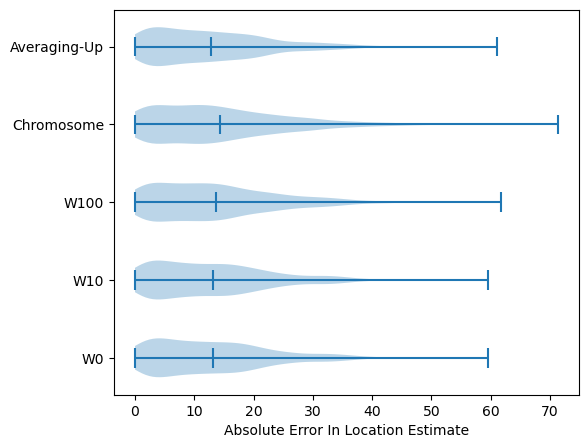

In [11]:
plt.figure(figsize=(6,5))
plt.violinplot([
    random_ancestors["window_0_abs_error_0"],
    random_ancestors["window_10_abs_error_0"],
    random_ancestors["window_100_abs_error_0"],
    random_ancestors["arg_abs_error_0"],
    random_ancestors["midpoint_abs_error_0"]
], showmeans=True, vert=False)
plt.yticks([1,2,3,4,5], ["W0", "W10", "W100", "Chromosome", "Averaging-Up"])
plt.xlabel("Absolute Error In Location Estimate")
plt.savefig("subfigures/Fig6_Accuracy.svg")
plt.show()

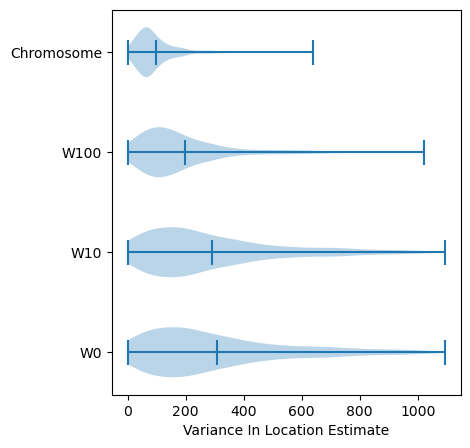

In [12]:
plt.figure(figsize=(4.5,5))
plt.violinplot([
    random_ancestors["window_0_variance_in_estimated_location_0"],
    random_ancestors["window_10_variance_in_estimated_location_0"],
    random_ancestors["window_100_variance_in_estimated_location_0"],
    random_ancestors["arg_variance_in_estimated_location_0"]
], showmeans=True, vert=False)
plt.yticks([1,2,3,4], ["W0", "W10", "W100", "Chromosome"])
plt.xlabel("Variance In Location Estimate")
plt.savefig("subfigures/Fig6_Variance.svg")
plt.show()

### Why are we getting worse error when using the full ARG compared to just the local tree?

This is very surprising as the full ARG shoud have more information than the local trees. The following plot shows that the ARG method is pulling ancestors too quickly into the center.

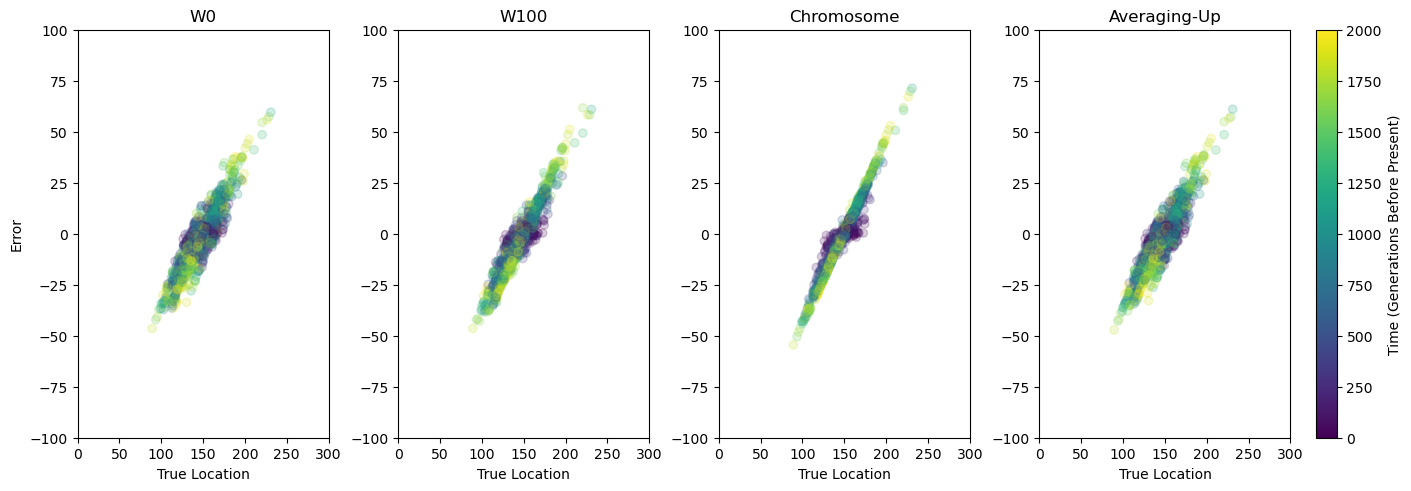

In [13]:
fig, ((ax0, ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=4, layout="constrained")

ax0.scatter(random_ancestors["true_location_0"], random_ancestors["window_0_error_0"], c=random_ancestors["time"], alpha=0.2, vmin=0, vmax=2000)
ax0.set_xlim([0, 300])
ax0.set_ylim([-100, 100])
ax0.set_title("W0")
ax0.set_ylabel("Error")
ax0.set_xlabel("True Location")
ax1.scatter(random_ancestors["true_location_0"], random_ancestors["window_100_error_0"], c=random_ancestors["time"], alpha=0.2, vmin=0, vmax=2000)
ax1.set_xlim([0, 300])
ax1.set_ylim([-100, 100])
ax1.set_title("W100")
ax1.set_xlabel("True Location")
ax2.scatter(random_ancestors["true_location_0"], random_ancestors["arg_error_0"], c=random_ancestors["time"], alpha=0.2, vmin=0, vmax=2000)
ax2.set_xlim([0, 300])
ax2.set_ylim([-100, 100])
ax2.set_title("Chromosome")
ax2.set_xlabel("True Location")
midpoint = ax3.scatter(random_ancestors["true_location_0"], random_ancestors["midpoint_error_0"], c=random_ancestors["time"], alpha=0.2, vmin=0, vmax=2000)
ax3.set_xlim([0, 300])
ax3.set_ylim([-100, 100])
ax3.set_title("Averaging-Up")
ax3.set_xlabel("True Location")

colorbar = fig.colorbar(midpoint, ax=ax3, label="Time (Generations Before Present)")
colorbar.solids.set(alpha=1)

fig.set_figwidth(14)
plt.savefig("subfigures/S_LocationBias.svg")
plt.show()

We do not see a bias in error when scanning across the genome.

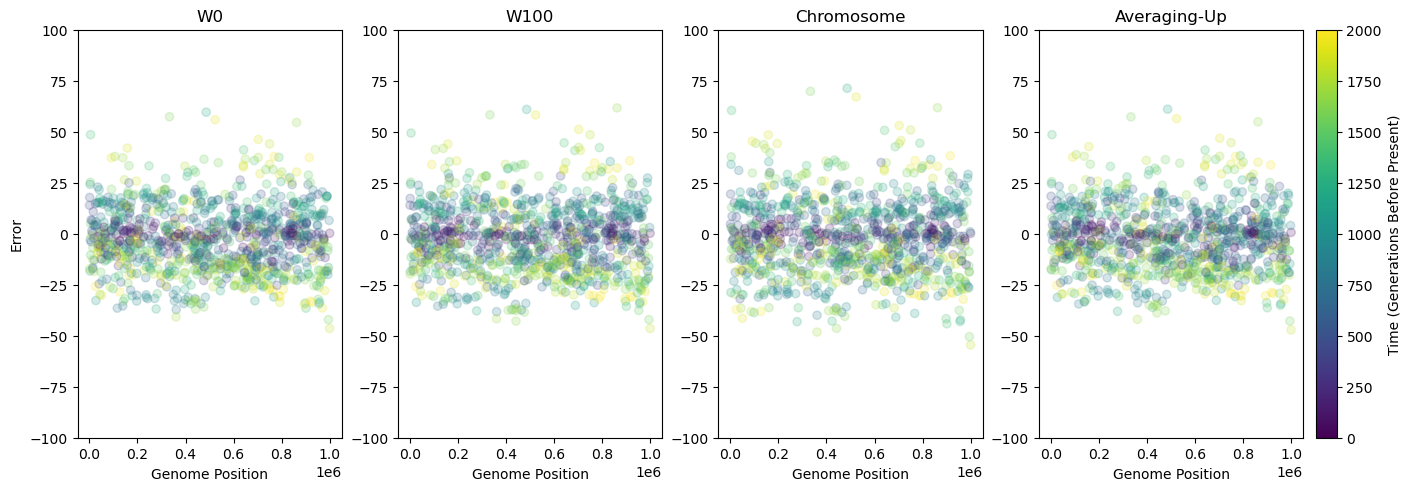

In [14]:
fig, ((ax0, ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=4, layout="constrained")

ax0.scatter(random_ancestors["genome_position"], random_ancestors["window_0_error_0"], c=random_ancestors["time"], alpha=0.2, vmin=0, vmax=2000)
ax0.set_ylim([-100, 100])
ax0.set_title("W0")
ax0.set_ylabel("Error")
ax0.set_xlabel("Genome Position")
ax1.scatter(random_ancestors["genome_position"], random_ancestors["window_100_error_0"], c=random_ancestors["time"], alpha=0.2, vmin=0, vmax=2000)
ax1.set_ylim([-100, 100])
ax1.set_title("W100")
ax1.set_xlabel("Genome Position")
ax2.scatter(random_ancestors["genome_position"], random_ancestors["arg_error_0"], c=random_ancestors["time"], alpha=0.2, vmin=0, vmax=2000)
ax2.set_ylim([-100, 100])
ax2.set_title("Chromosome")
ax2.set_xlabel("Genome Position")
midpoint = ax3.scatter(random_ancestors["genome_position"], random_ancestors["midpoint_error_0"], c=random_ancestors["time"], alpha=0.2, vmin=0, vmax=2000)
ax3.set_ylim([-100, 100])
ax3.set_title("Averaging-Up")
ax3.set_xlabel("Genome Position")

colorbar = fig.colorbar(midpoint, ax=ax3, label="Time (Generations Before Present)")
colorbar.solids.set(alpha=1)

fig.set_figwidth(14)
plt.savefig("subfigures/S_GenomePositionBias.svg")
plt.show()

### Coverage

The following section looks at how well the confidence intervals capture the true locations of the ancestors. As we increase the number of standard deviations out from the estimated location, we should capture more of the true locations. If our dispersal rate is the correct size (which it should be because we are using the theoretical effective dispersal rate), the coverage should fall very close to the expectation line.

In [8]:
std_arg = np.sqrt(random_ancestors["arg_variance_in_estimated_location_0"])
std_0 = np.sqrt(random_ancestors["window_0_variance_in_estimated_location_0"])
std_10 = np.sqrt(random_ancestors["window_10_variance_in_estimated_location_0"])
std_100 = np.sqrt(random_ancestors["window_100_variance_in_estimated_location_0"])

expected_zs = []
expected_percent_within = []
percent_within_arg = []
percent_within_w0 = []
percent_within_w10 = []
percent_within_w100 = []
for i in range(0,300):
    value = st.norm.cdf(i/100)
    expected_zs.append(i/100)
    expected_percent_within.append(value - (1-value))
    percent_within_arg.append(sum(random_ancestors["arg_abs_error_0"] <= std_arg*(i/100))/len(random_ancestors))
    percent_within_w0.append(sum(random_ancestors["window_0_abs_error_0"] <= std_0*(i/100))/len(random_ancestors))
    percent_within_w10.append(sum(random_ancestors["window_10_abs_error_0"] <= std_10*(i/100))/len(random_ancestors))
    percent_within_w100.append(sum(random_ancestors["window_100_abs_error_0"] <= std_100*(i/100))/len(random_ancestors))

/opt/anaconda3/envs/sparg_man/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


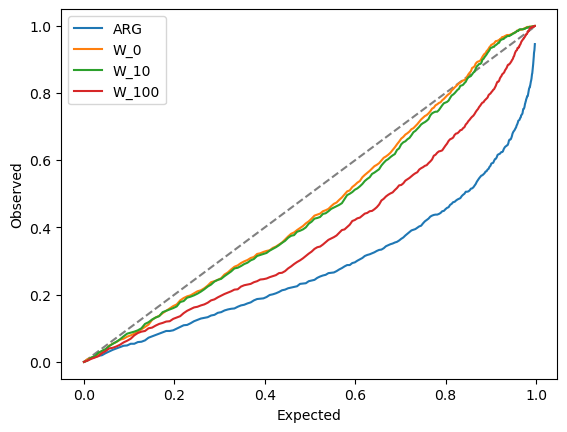

In [10]:
plt.plot(expected_percent_within, expected_percent_within, color="gray", linestyle='dashed')
plt.plot(expected_percent_within, percent_within_arg, label="ARG")
plt.plot(expected_percent_within, percent_within_w0, label="W_0")
plt.plot(expected_percent_within, percent_within_w10, label="W_10")
plt.plot(expected_percent_within, percent_within_w100, label="W_100")
plt.xlabel("Expected")
plt.ylabel("Observed")
plt.legend()
plt.savefig("subfigures/Fig6_Coverage.svg")
plt.show()